In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyMELTScalc as M
import sys
sys.path.append(r"H:\My Drive\2022\GitHub\pyMELTScalc\MELTS")

M.__version__

'0.1.9dev'

# Decompression calculations using Haleakala melt inclusion compositions

To demonstrate the ability of pyMELTScalc to perform decompression models, we have taken post-entrapment crystallisation corrected data from Haleakala melt inclusions from Moore et al. (2021; https://doi.org/10.1016/j.jvolgeores.2020.107144). One of the most notable aspects of this manuscript is that they measure the abundance of CO2 in both the gas bubble and the glass, providing estimates for the total CO2 content trapped during melt inclusions growth, and revealing high CO2 contents up to ~1.3 wt%.

First, we will load in their melt inclusion data, with the column headers formatted to be compatible with pyMELTScalc.

In [2]:
Data = pd.read_excel("Moore_Haleakala.xlsx")
Data.head()

,Sample,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Cr2O3_Liq,H2O_Liq,CO2_Liq,"CO2 (glass), ppm","ΔCO2 (bubble), ppm",P_bar_calc,T_C_calc
0,HA-16-6 xl 12 mi 1,45.432,1.796,12.529,1.341,11.427,0.177,12.187,10.751,2.338,0.760,0.338,0.051,0.866033,0.651909,3206.314610,3312.773070,5206.980906,1242
1,HA-16-6 xl 13 mi 1,46.559,1.032,12.185,1.334,11.437,0.144,12.606,10.830,2.603,0.343,0.109,0.042,0.765164,0.400832,2129.414579,1878.900536,3786.822268,1255
2,HA-16-6 xl 14 mi 1,45.571,2.166,14.298,1.524,11.330,0.186,9.137,10.682,3.014,0.895,0.373,0.045,0.770263,0.630188,2999.578344,3302.298054,4599.555788,1177
3,HA-16-6 xl 15 mi 1,45.794,2.263,14.155,1.575,11.224,0.193,8.464,11.271,2.668,0.985,0.471,0.048,0.866952,1.114211,2924.509125,8217.602940,6647.211193,1149
4,HA-16-6 xl 16 mi 1,44.423,3.143,15.524,2.131,10.729,0.191,6.625,10.926,3.504,1.168,0.483,0.035,1.118891,0.467146,3028.615490,1642.844984,3256.533160,1098


## Step 1 - determine saturation pressures

One of the first things that we can do with this data is determine the saturation pressure of each melt inclusion based on their major element, H2O and CO2 contents. The following cell determines the volatile saturation pressure of each melt inclusion and simultaneously solves for their liquidus temperature.

In [3]:
Sat_P = M.findSatPressure(Model = "MELTSv1.2.0", bulk = Data, T_C_init = 1200, P_bar_init = 5000)
Sat_P.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq,P_bar,T_Liq
0,45.164377,1.785420,12.455196,12.558452,0.175957,12.115211,10.687670,2.324228,0.755523,0.336009,0.860922,0.647532,0.095455,5830.0,1306.0
1,46.398243,1.028437,12.142928,12.592942,0.143503,12.562474,10.792607,2.594012,0.341816,0.108624,0.762510,0.398775,0.094929,4060.0,1308.0
2,45.310799,2.153633,14.216361,12.627909,0.184938,9.084830,10.621008,2.996791,0.889890,0.370870,0.765849,0.625375,0.107904,5760.0,1239.0
3,45.321288,2.239640,14.008884,12.509807,0.191008,8.376630,11.154654,2.640459,0.974832,0.466138,0.858000,1.102562,0.112045,9200.0,1276.0
4,44.232440,3.129518,15.457407,12.591015,0.190181,6.596581,10.879131,3.488969,1.162990,0.480928,1.114062,0.464287,0.151540,4190.0,1176.0


Plotting up the results reveals a main cluster of saturation pressures between approximately 4 - 6 kbar (near the base of the oceanic crust beneath Hawai'i), with some inclusions indicating extremely deep melt inclusion trapping down to ~9 kbar.

Text(0, 0.5, 'Density')

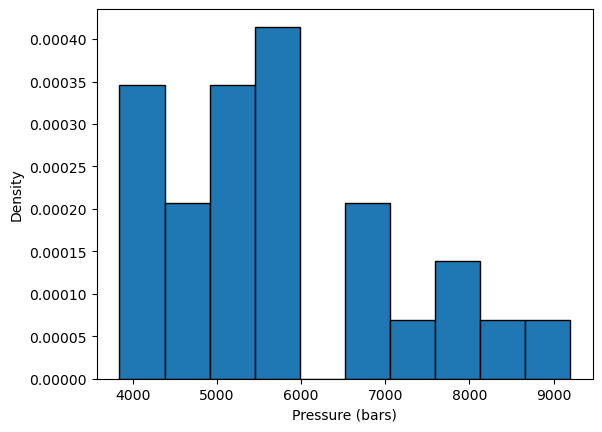

In [4]:
f, a = plt.subplots()
a.hist(Sat_P['P_bar'], density = True, edgecolor = 'k')
a.set_xlabel('Pressure (bars)')
a.set_ylabel('Density')

## Step 2 - Simulating isothermal decompression

Now that we have the appropriate saturation pressure and liquidus temperature (according to the rhyolite-MELTS v1.2.0 thermodynamic model), we can perform some degassing calculations to investigate how melt and fluid volatile compositions are expected to vary with depth, the volume fraction of fluid at any depth, and the difference between open-system and closed-system degassing paths.

To explore the possible calculations that can be performed we first isolate a single sample. Here a sample with high a high H2O concentration but relatively low CO2 abundance is chosen as an example:

In [4]:
bulk = Sat_P.loc[8]
bulk

SiO2_Liq        44.436168
TiO2_Liq         2.862126
Al2O3_Liq       14.817701
FeOt_Liq        12.591115
MnO_Liq          0.194262
MgO_Liq          7.938837
CaO_Liq         10.819890
Na2O_Liq         2.875076
K2O_Liq          1.295079
P2O5_Liq         0.415422
H2O_Liq          1.186077
CO2_Liq          0.393958
Fe3Fet_Liq       0.124295
P_bar         3840.000000
T_Liq         1185.000000
Name: 8, dtype: float64

In [5]:
Results = M.isothermal_decompression(Model = "MELTSv1.2.0", bulk = bulk,
                                     P_start_bar = bulk['P_bar'], P_end_bar = 50, dp_bar = 25,
                                     T_C = bulk['T_Liq'])

Running MELTSv1.2.0 calculation... Complete (time taken = 58.26 seconds)

Plotting up the results reveals that, as may be expected, the exsolved volatile phase is dominated by CO2 until pressures <1 kbar, when the proportion of H2O in the exsolved fluid begins to rapidly increase. It is at a similar pressure where the fluid mass fraction and fluid volume fraction start to rapidly increase, with the fluid volume fraction reaching a maximum value of 0.77 at the calculations minimum pressure (50 bars).

Text(0.5, 0, 'Fluid volume fraction')

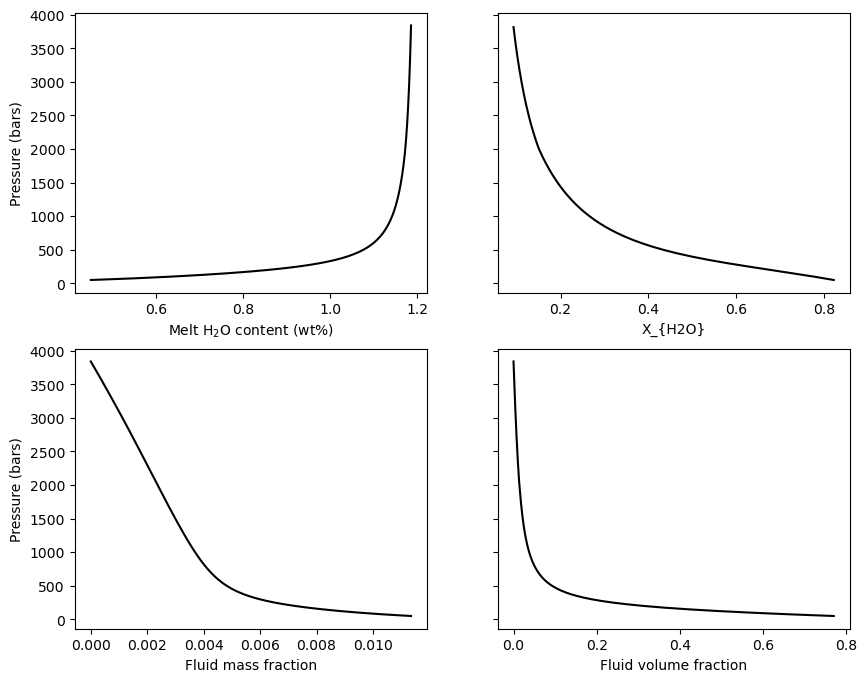

In [10]:
f, a = plt.subplots(2,2, figsize = (10,8), sharey = True)
a[0][0].plot(Results['All']['H2O_Liq'], Results['All']['P_bar'], '-k')
a[0][0].set_ylabel('Pressure (bars)')
a[0][0].set_xlabel('Melt H$_2$O content (wt%)')

XH2O = (Results['All']['H2O_fluid1']/18.01528)/(Results['All']['H2O_fluid1']/18.01528 + Results['All']['CO2_fluid1']/44.01)
a[0][1].plot(XH2O, Results['All']['P_bar'],'-k', label = 'X$_{H2O}$ ')
a[0][1].set_xlabel('X_{H2O}')

Mass_frac = Results['Mass']['fluid1']/(Results['Mass'].sum(axis = 1))
a[1][0].plot(Mass_frac, Results['All']['P_bar'], '-k')
a[1][0].set_xlabel('Fluid mass fraction')
a[1][0].set_ylabel('Pressure (bars)')

V_frac = Results['Volume']['fluid1']/(Results['Volume'].sum(axis = 1))
a[1][1].plot(V_frac, Results['All']['P_bar'], '-k')
a[1][1].set_xlabel('Fluid volume fraction')

We an also examine the degassing path in H2O-CO2 space as shown below:

Text(0, 0.5, 'CO$_2$ (wt%)')

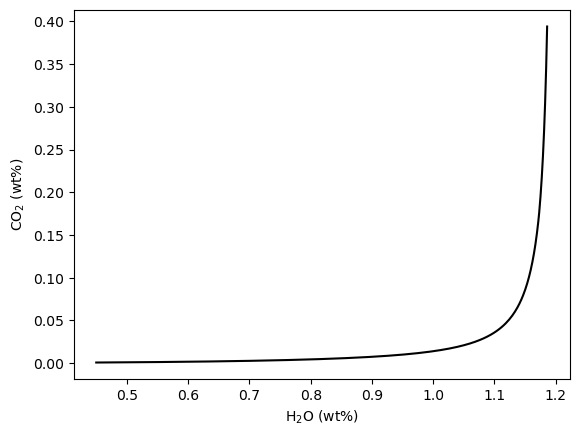

In [11]:
f, a = plt.subplots(1,1)
a.plot(Results['All']['H2O_Liq'], 
       Results['All']['CO2_Liq'], '-k')

a.set_xlabel('H$_2$O (wt%)')
a.set_ylabel('CO$_2$ (wt%)')

## Step 3 - determining decompression paths for all samples

Using the cells above, we could individually calculate the decompression path for every sample of interest by changing the sample used to define the 'bulk' variable. However, to do so would be tedius and pyMELTScalc allows for a much more efficient method of calculating decompression paths for multiple samples. Using exactly the same function, we can instead load in a full dataframe of compsitions (Sat_P) and simultaneously calculate the decompression paths for all samples. In the case shown here, the outputs are labelled by the string recorded in the 'Sample' column of dataframe Sat_P.

In [12]:
Sat_P['Sample'] = Data['Sample']
Results = M.isothermal_decompression(Model = "MELTSv1.2.0", bulk = Sat_P,
                                     P_start_bar = Sat_P['P_bar'], P_end_bar = 50, dp_bar = 25,
                                     T_C = Sat_P['T_Liq'], timeout = 600, label = "Sample")

  0%|          | 0/4 [00:00<?, ?it/s]

Running MELTSv1.2.0 calculations 0 to 7.0 ... Complete (time taken = 269.72 seconds)
Running MELTSv1.2.0 calculations 8 to 15.0 ... Complete (time taken = 275.57 seconds)
Running MELTSv1.2.0 calculations 16 to 23.0 ... Complete (time taken = 251.36 seconds)
Running MELTSv1.2.0 calculations 24 to 26.0 ... Complete (time taken = 128.56 seconds)
dict_keys(['HA-16-6 xl 13 mi 1', 'HA-16-6 xl 12 mi 1', 'HA-16-6 xl 16 mi 1', 'HA-16-6 xl 2 mi 3', 'HA-16-6 xl 21 mi 1', 'HA-16-6 xl 14 mi 1', 'HA-16-6 xl 22 mi 1', 'HA-16-6 xl 15 mi 1', 'HA-16-6 xl 23 mi 1', 'HA-16-6 xl 24 mi 1', 'HA-16-6 xl 25 mi 2', 'HA-16-6 xl 31 mi 1', 'HA-16-6 xl 27 mi 1', 'HA-16-6 xl 29 mi 1', 'HA-16-6 xl 3 mi 1', 'HA-16-6 xl 25 mi 1', 'HA-16-7 xl 18 mi 1', 'HA-16-7 xl 11 mi 2', 'HA-16-7 xl 23 mi 1', 'HA-16-7 xl 17 mi 3', 'HA-16-6 xl 32 mi 2', 'HA-16-7 xl 19 mi 2', 'HA-16-7 xl 14 mi 1', 'HA-16-7 xl 24 mi 1', 'HA-16-7 xl 26 mi 1', 'HA-16-7 xl 31 mi 1', 'HA-16-7 xl 29 mi 1'])


Rather than plotting the results for all possible samples, we choose 4 samples with a range of volatile contents to examine the differin decompression paths.

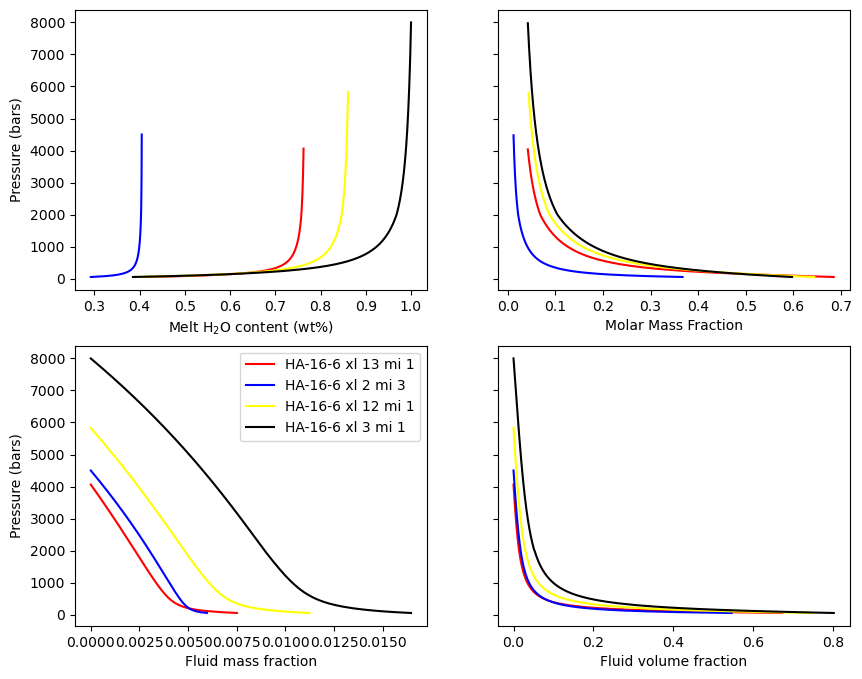

In [13]:
Samples = {'HA-16-6 xl 13 mi 1': 'red', 
           'HA-16-6 xl 2 mi 3': 'blue',
           'HA-16-6 xl 12 mi 1': 'yellow',
           'HA-16-6 xl 3 mi 1': 'black'}

f, a = plt.subplots(2,2, figsize = (10,8), sharey = True)
a[1][0].set_xlabel('Fluid mass fraction')
a[1][0].set_ylabel('Pressure (bars)')
a[0][0].set_ylabel('Pressure (bars)')
a[0][1].set_xlabel('Molar Mass Fraction')
a[1][1].set_xlabel('Fluid volume fraction')
a[0][0].set_xlabel('Melt H$_2$O content (wt%)')
                   
for r in Samples:
    a[0][0].plot(Results[r]['All']['H2O_Liq'], Results[r]['All']['P_bar'], '-', color = Samples[r])
    
    XH2O = (Results[r]['All']['H2O_fluid1']/18.01528)/(Results[r]['All']['H2O_fluid1']/18.01528 + Results[r]['All']['CO2_fluid1']/44.01)
    a[0][1].plot(XH2O, Results[r]['All']['P_bar'],'-', color = Samples[r])

    Mass_frac = Results[r]['Mass']['fluid1']/(Results[r]['Mass'].sum(axis = 1))
    a[1][0].plot(Mass_frac, Results[r]['All']['P_bar'], '-', color = Samples[r], label = r)

    V_frac = Results[r]['Volume']['fluid1']/(Results[r]['Volume'].sum(axis = 1))
    a[1][1].plot(V_frac, Results[r]['All']['P_bar'], '-', color = Samples[r])
    
a[1][0].legend()
    

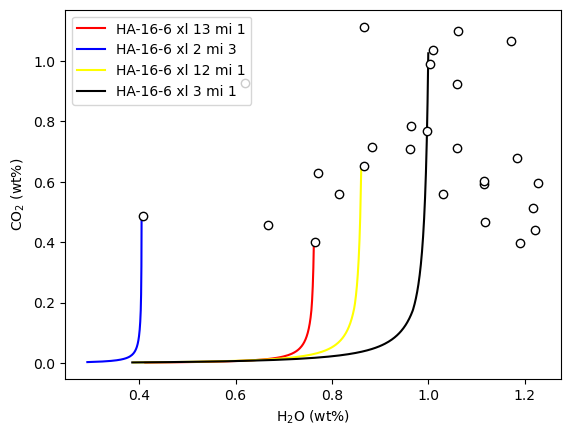

In [14]:
f, a = plt.subplots(1,1)
for r in Samples:
    a.plot(Results[r]['All']['H2O_Liq'], 
           Results[r]['All']['CO2_Liq'], '-', color = Samples[r], label = r)
    
a.plot(Data['H2O_Liq'], Data['CO2_Liq'], 'ok', mfc = "white")

a.set_xlabel('H$_2$O (wt%)')
a.set_ylabel('CO$_2$ (wt%)')
a.legend()

## Step 4 - Open vs Closed system degassing

So far, all calculations have been performed assuming closed system degassing (i.e., the fluid and melt phases remain in equilibrium during magma ascent). In natural systems, it is possible that this equilibrium between melt and fluid is not maintained, and instead the fluid phase becomes chemically isolated from the ascending melt. To examine how open system degassing might influence our results, we can simply run the sample calculation, but set 'Frac_fluid' to True. Here, we have also saved the previous results from the closed system degassing calculations into a Python dictionary called 'Closed', with the new results for open system degassing saved in a corresponding dictionary termed 'Open'.

In [15]:
Closed = Results.copy()
Open = M.isothermal_decompression(Model = "MELTSv1.2.0", bulk = Data,
                                     P_start_bar = Sat_P['P_bar'], P_end_bar = 50, dp_bar = 25,
                                     T_C = Sat_P['T_Liq'], timeout = 600, label = "Sample", Frac_fluid = True)

  0%|          | 0/4 [00:00<?, ?it/s]

Running MELTSv1.2.0 calculations 0 to 7.0 ... Complete (time taken = 251.03 seconds)
Running MELTSv1.2.0 calculations 8 to 15.0 ... Complete (time taken = 266.51 seconds)
Running MELTSv1.2.0 calculations 16 to 23.0 ... Complete (time taken = 303.49 seconds)
Running MELTSv1.2.0 calculations 24 to 26.0 ... Complete (time taken = 134.88 seconds)
dict_keys(['HA-16-6 xl 13 mi 1', 'HA-16-6 xl 12 mi 1', 'HA-16-6 xl 2 mi 3', 'HA-16-6 xl 21 mi 1', 'HA-16-6 xl 16 mi 1', 'HA-16-6 xl 14 mi 1', 'HA-16-6 xl 22 mi 1', 'HA-16-6 xl 15 mi 1', 'HA-16-6 xl 23 mi 1', 'HA-16-6 xl 24 mi 1', 'HA-16-6 xl 25 mi 2', 'HA-16-6 xl 31 mi 1', 'HA-16-6 xl 27 mi 1', 'HA-16-6 xl 29 mi 1', 'HA-16-6 xl 25 mi 1', 'HA-16-6 xl 3 mi 1', 'HA-16-7 xl 18 mi 1', 'HA-16-7 xl 11 mi 2', 'HA-16-7 xl 23 mi 1', 'HA-16-7 xl 17 mi 3', 'HA-16-6 xl 32 mi 2', 'HA-16-7 xl 19 mi 2', 'HA-16-7 xl 14 mi 1', 'HA-16-7 xl 24 mi 1', 'HA-16-7 xl 26 mi 1', 'HA-16-7 xl 31 mi 1', 'HA-16-7 xl 29 mi 1'])


Considering the results of these decompression calculations, clear differences between the closed and open system degassing paths appear, consistent with what has previously been reported in other magma decompression models.

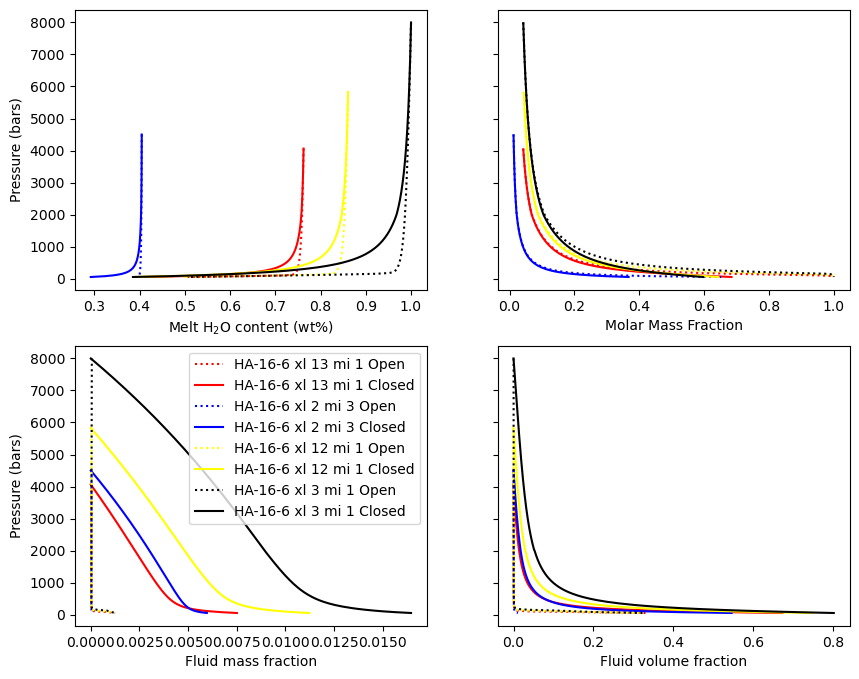

In [18]:
f, a = plt.subplots(2,2, figsize = (10,8), sharey = True)
a[1][0].set_xlabel('Fluid mass fraction')
a[1][0].set_ylabel('Pressure (bars)')
a[0][0].set_ylabel('Pressure (bars)')
a[0][1].set_xlabel('Molar Mass Fraction')
a[1][1].set_xlabel('Fluid volume fraction')
a[0][0].set_xlabel('Melt H$_2$O content (wt%)')
                   
for r in Samples:
    a[0][0].plot(Open[r]['All']['H2O_Liq'], Open[r]['All']['P_bar'], ':', color = Samples[r])
    a[0][0].plot(Closed[r]['All']['H2O_Liq'], Closed[r]['All']['P_bar'], '-', color = Samples[r])
    
    XH2O_Open = (Open[r]['All']['H2O_fluid1']/18.01528)/(Open[r]['All']['H2O_fluid1']/18.01528 + Open[r]['All']['CO2_fluid1']/44.01)
    XH2O_Closed = (Closed[r]['All']['H2O_fluid1']/18.01528)/(Closed[r]['All']['H2O_fluid1']/18.01528 + Closed[r]['All']['CO2_fluid1']/44.01)
    a[0][1].plot(XH2O_Open, Open[r]['All']['P_bar'],':', color = Samples[r])
    a[0][1].plot(XH2O_Closed, Closed[r]['All']['P_bar'],'-', color = Samples[r])

    Mass_frac_Open = Open[r]['Mass']['fluid1']/(Open[r]['Mass'].sum(axis = 1))
    Mass_frac_Closed = Closed[r]['Mass']['fluid1']/(Closed[r]['Mass'].sum(axis = 1))
    a[1][0].plot(Mass_frac_Open, Open[r]['All']['P_bar'], ':', color = Samples[r], label = r + ' Open')
    a[1][0].plot(Mass_frac_Closed, Closed[r]['All']['P_bar'], '-', color = Samples[r], label = r + ' Closed')

    V_frac_Open = Open[r]['Volume']['fluid1']/(Open[r]['Volume'].sum(axis = 1))
    V_frac_Closed = Closed[r]['Volume']['fluid1']/(Closed[r]['Volume'].sum(axis = 1))
    a[1][1].plot(V_frac_Open, Open[r]['All']['P_bar'], ':', color = Samples[r])
    a[1][1].plot(V_frac_Closed, Closed[r]['All']['P_bar'], '-', color = Samples[r])
    
a[1][0].legend()

One of the most notable differences between the two types of models is that in open system degassing, the H2O content of the ascending magma remains nearly constant until very low pressures.

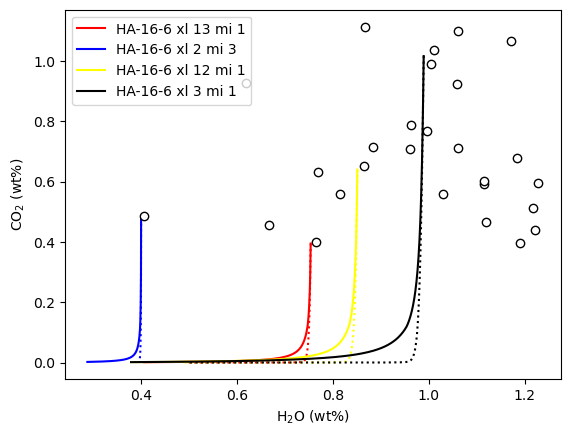

In [13]:
f, a = plt.subplots(1,1)
for r in Samples:
    a.plot(Closed[r]['All']['H2O_Liq'], 
           Closed[r]['All']['CO2_Liq'], '-', color = Samples[r], label = r)
    a.plot(Open[r]['All']['H2O_Liq'], 
           Open[r]['All']['CO2_Liq'], ':', color = Samples[r])
    
a.plot(Data['H2O_Liq'], Data['CO2_Liq'], 'ok', mfc = "white")

a.set_xlabel('H$_2$O (wt%)')
a.set_ylabel('CO$_2$ (wt%)')
a.legend()

## Step 5 - imposing different thermal constraints on magma decompression paths/

In the calculations above, we have assumed that the temperature of the magma stays constant during decompression. In nature this may not always be the case, and one possible alternative scenario is that the magma ascents adiabatically (i.e., without transfer of heat into or out of the conduit). Using pyMELTScalc, we can model adiabatic (isentropic) magma ascent in a similar way to isothermal magma ascent, with the only difference being that the specified temprature in the function represents only the initial/starting temperature of the decompression path.

In [19]:
# Comparing isothemal and isentropic decompression
Isothermal = M.isothermal_decompression(Model = "MELTSv1.2.0", bulk = bulk,
                                     P_start_bar = bulk['P_bar'], P_end_bar = 50, dp_bar = 25,
                                     T_C = bulk['T_Liq'], timeout = 300)

Isentropic = M.isentropic_decompression(Model = "MELTSv1.2.0", bulk = bulk,
                                     P_start_bar = bulk['P_bar'], P_end_bar = 50, dp_bar = 25,
                                     T_C = bulk['T_Liq'], timeout = 300)

Running MELTSv1.2.0 calculation... Complete (time taken = 77.1 seconds)Running MELTSv1.2.0 calculation... Complete (time taken = 134.84 seconds)

Comparing the isothermal and isentropic decompression paths for a single composition reveals, as expected, that the temperature vs pressure relationship of the two models differ. However, despite the ~15 $^{o} C$ temperature offset between the two models, there is no observable difference in the fluid composition, or mass/volume fractions with pressure.

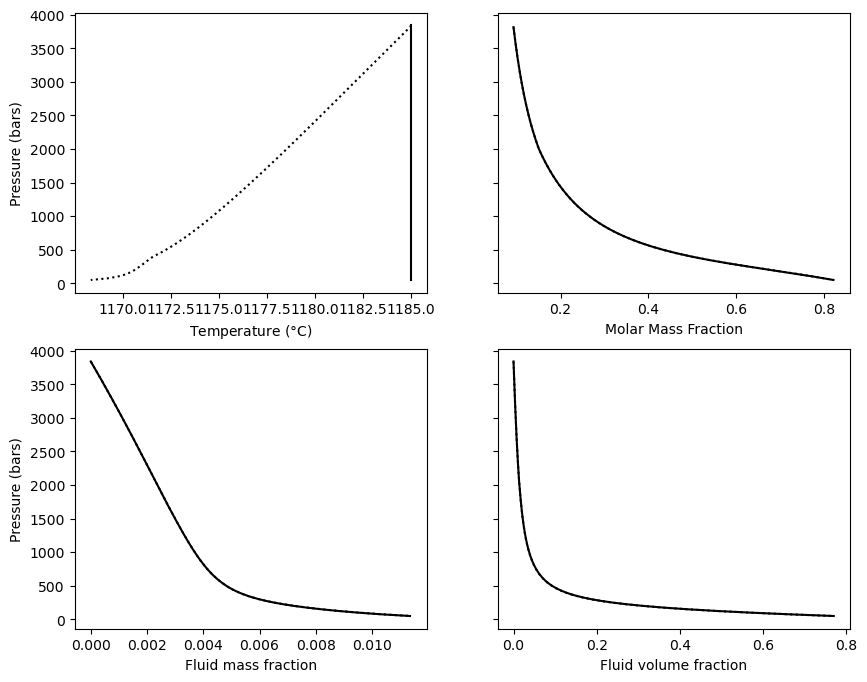

In [20]:
f, a = plt.subplots(2,2, figsize = (10,8), sharey = True)
a[1][0].set_xlabel('Fluid mass fraction')
a[1][0].set_ylabel('Pressure (bars)')
a[0][0].set_ylabel('Pressure (bars)')
a[0][1].set_xlabel('Molar Mass Fraction')
a[1][1].set_xlabel('Fluid volume fraction')
a[0][0].set_xlabel('Temperature ($\degree C$)')
                   
# calculate results for isothermal system degassing
a[0][0].plot(Isothermal['All']['T_C'], Isothermal['All']['P_bar'], '-', color = 'k', label = 'Isothermal degassing')

XH2O = (Isothermal['All']['H2O_fluid1']/18.01528)/(Isothermal['All']['H2O_fluid1']/18.01528 + Isothermal['All']['CO2_fluid1']/44.01)
a[0][1].plot(XH2O, Isothermal['All']['P_bar'],'-', color = 'k', label = 'X$_{H2O}$ Isothermal')
# a[0][1].plot(1-XH2O, Isothermal['All']['P_bar'],'--', color = 'k', label = 'X$_{CO2}$ ' + r)

Mass_frac = Isothermal['Mass']['fluid1']/(Isothermal['Mass'].sum(axis = 1))
a[1][0].plot(Mass_frac, Isothermal['All']['P_bar'], '-', color = 'k')

V_frac = Isothermal['Volume']['fluid1']/(Isothermal['Volume'].sum(axis = 1))
a[1][1].plot(V_frac, Isothermal['All']['P_bar'], '-', color = 'k')

# calculate results for isothermal system degassing
a[0][0].plot(Isentropic['All']['T_C'], Isentropic['All']['P_bar'], ':', color = 'k', label = 'Isentropic degassing')

XH2O = (Isentropic['All']['H2O_fluid1']/18.01528)/(Isentropic['All']['H2O_fluid1']/18.01528 + Isentropic['All']['CO2_fluid1']/44.01)
a[0][1].plot(XH2O, Isentropic['All']['P_bar'],':', color = 'k', label = 'X$_{H2O}$ Isentropic')
# a[0][1].plot(1-XH2O, Isentropic['All']['P_bar'],'-.', color = 'k', label = 'X$_{CO2}$ ' + r)

Mass_frac = Isentropic['Mass']['fluid1']/(Isentropic['Mass'].sum(axis = 1))
a[1][0].plot(Mass_frac, Isentropic['All']['P_bar'], ':', color = 'k')

V_frac = Isentropic['Volume']['fluid1']/(Isentropic['Volume'].sum(axis = 1))
a[1][1].plot(V_frac, Isentropic['All']['P_bar'], ':', color = 'k')

a[0][0].legend()

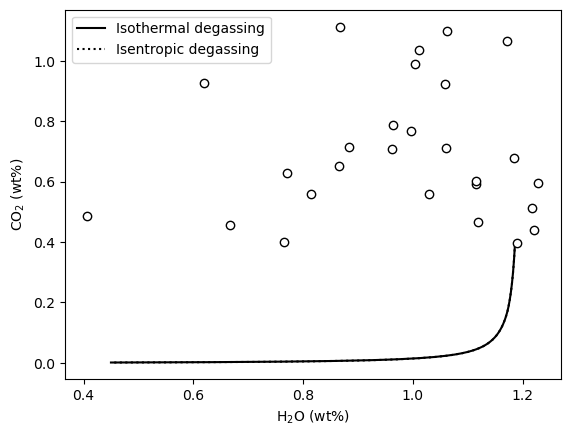

In [21]:
f, a = plt.subplots(1,1)
a.plot(Isothermal['All']['H2O_Liq'], 
       Isothermal['All']['CO2_Liq'], '-', color = Samples[r], label = 'Isothermal degassing')
a.plot(Isentropic['All']['H2O_Liq'], 
       Isentropic['All']['CO2_Liq'], ':', color = Samples[r], label = 'Isentropic degassing')
    
a.plot(Data['H2O_Liq'], Data['CO2_Liq'], 'ok', mfc = "white")

a.set_xlabel('H$_2$O (wt%)')
a.set_ylabel('CO$_2$ (wt%)')
a.legend()

## Step 6 - modelling magma decompression if the initial volatile content is unknown

For many systems, the absolute amount of CO2 or H2O in the magma at the time of melt inclusion entrapment might not be accurately known. This could be due to the influence of secondary processes such as decrepitation or volatile-loss by diffusion, or incorrectly accounting for (or failing to account for) the amount of CO2 that is contained within vapour bubbles.

For this reason, pyMELTScalc also enables users to examine decompression paths using a range of different initial volatile contents for a single major element composition. To do so, an array of values must be passed under the 'H2O_Liq' or 'CO2_Liq' variables. If an array of both H2O and CO2 is passed these must be the sample length. PyMELTScalc also gives users the option to label thei outputs based on the inputtd H2O or CO2 contents. For example, taking the same composition used above, which has a high H2O content but lower than average CO2 content for the Haleakala inclusions, we can examine how the decompression paths might vary if the CO2 content of the carrier melt was higher than indicated by this measurement.

In [22]:
## comparing degassing at unknown CO2 contents
# Comparing isothemal and isentropic decompression
Isothermal = M.isothermal_decompression(Model = "MELTSv1.2.0", bulk = bulk,
                                     P_start_bar = 15000, P_end_bar = 50, dp_bar = 25,
                                     find_liquidus = True, timeout = 1200,
                                       CO2_Liq = np.array([0.01, 0.1, 0.5, 1]), label = "CO2")

Isentropic = M.isentropic_decompression(Model = "MELTSv1.2.0", bulk = bulk,
                                     P_start_bar = 15000, P_end_bar = 50, dp_bar = 25,
                                     find_liquidus = True, timeout = 1200,
                                       CO2_Liq = np.array([0.01, 0.1, 0.5, 1]), label = "CO2")

  0%|          | 0/1 [00:00<?, ?it/s]

Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 258.78 seconds)
dict_keys(['CO2 = 0.01 wt%', 'CO2 = 0.1 wt%', 'CO2 = 0.5 wt%', 'CO2 = 0.99 wt%'])


  0%|          | 0/1 [00:00<?, ?it/s]

Running MELTSv1.2.0 calculations 0 to 3.0 ... Complete (time taken = 321.93 seconds)
dict_keys(['CO2 = 0.01 wt%', 'CO2 = 0.1 wt%', 'CO2 = 0.5 wt%', 'CO2 = 0.99 wt%'])


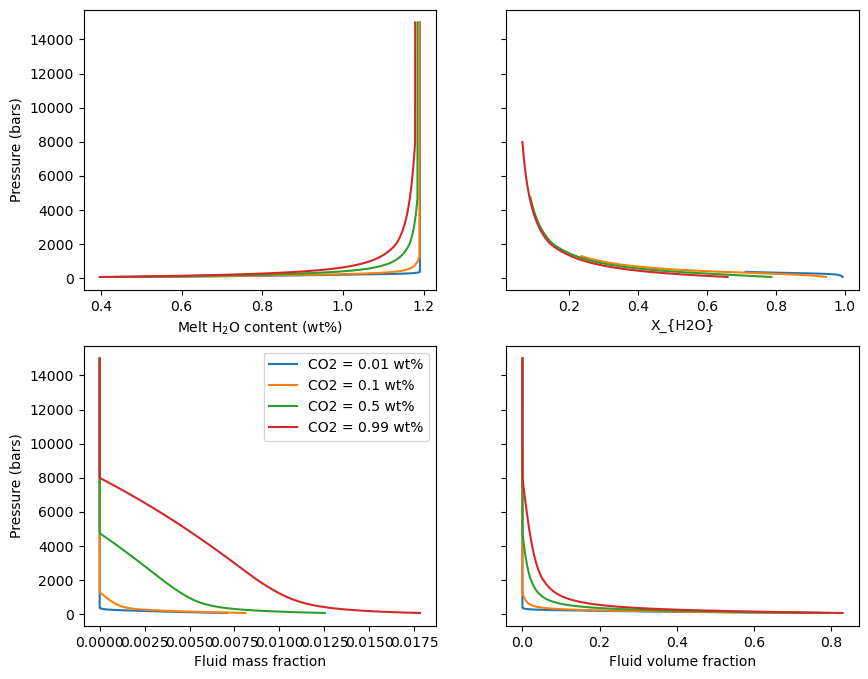

In [25]:
f, a = plt.subplots(2,2, figsize = (10,8), sharey = True)
a[1][0].set_xlabel('Fluid mass fraction')
a[1][0].set_ylabel('Pressure (bars)')
a[0][1].set_xlabel('X$_{H2O}$')
a[0][0].set_ylabel('Pressure (bars)')
a[1][1].set_xlabel('Fluid volume fraction')
a[0][0].set_xlabel('Melt H$_2$O content (wt%)')

for r in Isothermal:
    a[0][0].plot(Isothermal[r]['All']['H2O_Liq'], Isothermal[r]['All']['P_bar'], '-')
    
    XH2O = (Isothermal[r]['All']['H2O_fluid1']/18.01528)/(Isothermal[r]['All']['H2O_fluid1']/18.01528 + Isothermal[r]['All']['CO2_fluid1']/44.01)
    a[0][1].plot(XH2O, Isothermal[r]['All']['P_bar'],'-')

    Mass_frac = Isothermal[r]['Mass']['fluid1']/(Isothermal[r]['Mass'].sum(axis = 1))
    a[1][0].plot(Mass_frac, Isothermal[r]['All']['P_bar'], '-', label = r)

    V_frac = Isothermal[r]['Volume']['fluid1']/(Isothermal[r]['Volume'].sum(axis = 1))
    a[1][1].plot(V_frac, Isothermal[r]['All']['P_bar'], '-')
    
a[1][0].legend()

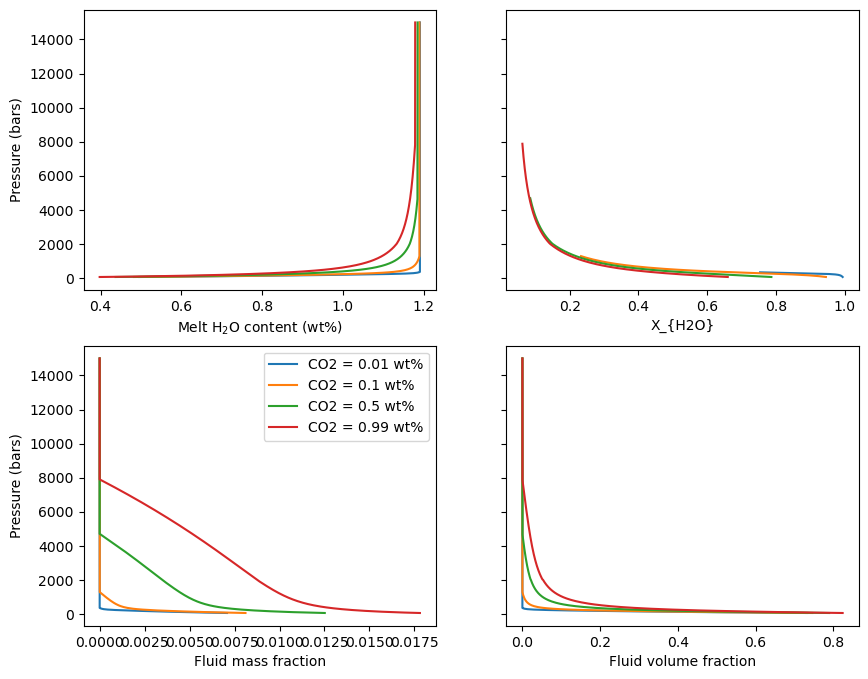

In [26]:
f, a = plt.subplots(2,2, figsize = (10,8), sharey = True)
a[1][0].set_xlabel('Fluid mass fraction')
a[1][0].set_ylabel('Pressure (bars)')
a[0][1].set_xlabel('X$_{H2O}$')
a[0][0].set_ylabel('Pressure (bars)')
a[1][1].set_xlabel('Fluid volume fraction')
a[0][0].set_xlabel('Melt H$_2$O content (wt%)')

for r in Isentropic:
    a[0][0].plot(Isentropic[r]['All']['H2O_Liq'], Isentropic[r]['All']['P_bar'], '-')
    
    XH2O = (Isentropic[r]['All']['H2O_fluid1']/18.01528)/(Isentropic[r]['All']['H2O_fluid1']/18.01528 + Isentropic[r]['All']['CO2_fluid1']/44.01)
    a[0][1].plot(XH2O, Isentropic[r]['All']['P_bar'],'-')

    Mass_frac = Isentropic[r]['Mass']['fluid1']/(Isentropic[r]['Mass'].sum(axis = 1))
    a[1][0].plot(Mass_frac, Isentropic[r]['All']['P_bar'], '-', label = r)

    V_frac = Isentropic[r]['Volume']['fluid1']/(Isentropic[r]['Volume'].sum(axis = 1))
    a[1][1].plot(V_frac, Isentropic[r]['All']['P_bar'], '-')
    
a[1][0].legend()

In [23]:
A = ['1', '0.5']
B = [float(x) for x in A]
for b in B:
    if b%1 == 0:
        print(int(b))
    else:
        print(b)


1
0.5
